In [3]:
# Example: Using PARSEC isochrones
# Download from: http://stev.oapd.inaf.it/cgi-bin/cmd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load isochrone (you'd download this for your specific parameters)
def load_isochrone(age_gyr, metallicity_feh, distance_pc, extinction_Av):
    """
    Load and transform isochrone to observable CMD
    
    Returns: (g-r)_iso, g_iso as functions of initial mass
    """
    # This would load actual PARSEC file
    # For now, we simulate with dummy data
    
    # Theoretical isochrone in absolute magnitudes
    M_g_theory = np.linspace(-4, 12, 100)  # Absolute mag
    color_theory = some_isochrone_model(M_g_theory, age_gyr, metallicity_feh)
    
    # Apply distance modulus
    mu = 5 * np.log10(distance_pc) - 5
    g_apparent = M_g_theory + mu
    
    # Apply reddening
    A_g = 3.303 * extinction_Av  # Cardelli et al. extinction law
    A_r = 2.285 * extinction_Av
    
    g_apparent += A_g
    color_obs = color_theory + (A_g - A_r)
    
    return color_obs, g_apparent

# For M2
age_M2 = 12.5  # Gyr
feh_M2 = -1.6
dist_M2 = 11500  # pc
Av_M2 = 0.06 * 3.1  # Convert E(B-V) to Av

color_iso_M2, g_iso_M2 = load_isochrone(age_M2, feh_M2, dist_M2, Av_M2)

NameError: name 'some_isochrone_model' is not defined

## 2. CMD-Based Membership: Isochrone Distance Metric

### Physical Basis

Stars in a cluster formed from the same molecular cloud and thus share:
- **Common age** ($\tau$): Sets main-sequence turnoff point
- **Common metallicity** ([Fe/H]): Affects color-temperature relation
- **Common distance** ($d$): Determines apparent magnitude via distance modulus
- **Common reddening** ($E(B-V)$): Shifts color and magnitude

These parameters uniquely define an **isochrone** in the CMD.

### Distance Metric

For each star, we compute the **minimum distance** to the isochrone, normalized by photometric uncertainties:

$$d_{\text{CMD}}(i) = \min_{j \in \text{isochrone}} \sqrt{\left(\frac{g_i - g_{\text{iso},j}}{\sigma_{g,i}}\right)^2 + \left(\frac{(g-r)_i - (g-r)_{\text{iso},j}}{\sigma_{g-r,i}}\right)^2}$$

This is the **Mahalanobis distance** assuming uncorrelated errors.

The membership probability is:

$$P_{\text{CMD}}(i) = \exp\left[-\frac{d_{\text{CMD}}^2(i)}{2}\right]$$

Interpretation:
- $d_{\text{CMD}} = 1$: Star is 1$\sigma$ from isochrone → $P = 0.61$
- $d_{\text{CMD}} = 2$: Star is 2$\sigma$ from isochrone → $P = 0.14$
- $d_{\text{CMD}} = 3$: Star is 3$\sigma$ from isochrone → $P = 0.01$

### Implementation

**For real data**, download PARSEC or MIST isochrones:
- PARSEC: http://stev.oapd.inaf.it/cgi-bin/cmd
- MIST: http://waps.cfa.harvard.edu/MIST/

Then apply distance modulus and extinction corrections.

---

## 1. Theoretical Background: Why Multi-Dimensional Membership?

### The Contamination Problem

Consider M34 (open cluster at 470 pc):
- **Estimated members**: ~200-400 stars
- **Field stars in field of view**: ~10,000 stars
- **Contamination ratio**: 25:1

Using a single criterion (e.g., CMD) gives:
- True member acceptance: 90%
- Field star rejection: 98%
- **False positive rate**: Still 2% × 10,000 = 200 contaminants!

### Power of Multi-Dimensional Cuts

If criteria are independent and each rejects 98% of field stars:
- Combined rejection: $1 - (1-0.98)^3 = 99.9992\%$
- Contaminants: 0.02% × 10,000 = 2 stars
- **Improvement factor**: 100×

### Statistical Independence Assumption

CMD, PM, and spatial positions are largely independent for field stars:
- CMD depends on: star's age, metallicity, distance
- PM depends on: Galactic orbit, solar reflex motion
- Position depends on: line of sight projection (random)

For cluster members, these are **correlated** (common origin), but for field stars they are **uncorrelated**.

**Key insight**: Multiplication of likelihoods dramatically suppresses field star contamination while preserving cluster members.

---

# Stellar Cluster Membership Determination

**A Comprehensive Bayesian Framework for M2 and M34**

---

## Overview

This notebook implements a **multi-dimensional Bayesian membership determination** framework that combines three independent observational constraints:

1. **Color-Magnitude Diagram (CMD) filtering** - Stars follow isochrones  
2. **Proper Motion analysis** - Cluster members share coherent motion  
3. **Spatial distribution** - Members follow centrally concentrated profiles  

### Physical Motivation

Star clusters are gravitationally bound systems embedded in the Galactic field. Separating cluster members from contaminants requires leveraging multiple observables:

- **CMD**: Cluster stars share common age, metallicity, distance → follow theoretical isochrone  
- **Proper Motion**: Cluster has coherent space velocity → tight PM distribution  
- **Spatial**: Cluster has radial density profile → centrally concentrated  

Field stars are scattered in all three dimensions, enabling probabilistic separation.

### Statistical Framework

For each star $i$, we compute the posterior membership probability:

$$P(\text{member} | \text{data}) = \frac{\mathcal{L}_{\text{cluster}}(\text{data}) \cdot P_{\text{prior}}}{\mathcal{L}_{\text{cluster}}(\text{data}) \cdot P_{\text{prior}} + \mathcal{L}_{\text{field}}(\text{data}) \cdot (1 - P_{\text{prior}})}$$

where the combined likelihood is:

$$\mathcal{L} = \mathcal{L}_{\text{CMD}} \times \mathcal{L}_{\text{PM}} \times \mathcal{L}_{\text{spatial}}$$

assuming statistical independence.

---

## Notebook Contents

1. **Theoretical Background** - Physical and statistical foundations
2. **CMD-Based Membership** - Isochrone fitting and distance metrics  
3. **Proper Motion Analysis** - Gaia data, cluster detection, Gaussian mixture models  
4. **Spatial Distribution** - Radial profiles and background estimation  
5. **Bayesian Combination** - Full posterior calculation  
6. **Advanced Methods** - Iterative refinement, hierarchical Bayes, machine learning

---

In [ ]:
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

def isochrone_distance(stars_color, stars_mag, iso_color, iso_mag, 
                       sigma_color, sigma_mag):
    """
    Compute distance of each star to isochrone in CMD space.
    
    Parameters:
    -----------
    stars_color : array (N_stars,)
        Observed colors
    stars_mag : array (N_stars,)
        Observed magnitudes
    iso_color : array (N_iso,)
        Isochrone colors
    iso_mag : array (N_iso,)
        Isochrone magnitudes
    sigma_color, sigma_mag : arrays (N_stars,)
        Photometric uncertainties
    
    Returns:
    --------
    distances : array (N_stars,)
        Normalized distance to isochrone
    """
    N_stars = len(stars_color)
    N_iso = len(iso_color)
    
    # Normalize coordinates
    stars_normalized = np.column_stack([
        stars_color / sigma_color,
        stars_mag / sigma_mag
    ])
    
    iso_normalized = np.column_stack([
        iso_color / np.median(sigma_color),  # Use typical uncertainty
        iso_mag / np.median(sigma_mag)
    ])
    
    # Compute distance matrix (N_stars × N_iso)
    dist_matrix = cdist(stars_normalized, iso_normalized, metric='euclidean')
    
    # Minimum distance to isochrone for each star
    distances = np.min(dist_matrix, axis=1)
    
    return distances

def cmd_membership_probability(stars_color, stars_mag, iso_color, iso_mag,
                                sigma_color, sigma_mag, n_sigma=3):
    """
    Compute CMD-based membership probability.
    """
    distances = isochrone_distance(stars_color, stars_mag, iso_color, iso_mag,
                                    sigma_color, sigma_mag)
    
    # Gaussian probability
    prob = np.exp(-0.5 * distances**2)
    
    # Hard cut at n_sigma
    prob[distances > n_sigma] = 0.0
    
    return prob, distances

# Example usage
# Your observed stars
N_stars = 1000
stars_g = your_photometry['g']
stars_r = your_photometry['r']
stars_color = stars_g - stars_r
sigma_g = your_photometry['sigma_g']
sigma_r = your_photometry['sigma_r']
sigma_color = np.sqrt(sigma_g**2 + sigma_r**2)

# Compute membership
P_cmd, d_cmd = cmd_membership_probability(
    stars_color, stars_g, 
    color_iso_M2, g_iso_M2,
    sigma_color, sigma_g,
    n_sigma=3.0
)

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(stars_color, stars_g, c=P_cmd, s=5, cmap='RdYlGn', vmin=0, vmax=1)
plt.plot(color_iso_M2, g_iso_M2, 'k-', lw=2, label='Isochrone')
plt.colorbar(label='$P_{CMD}$')
plt.xlabel('g - r')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.legend()
plt.title('CMD with Membership Probability')

plt.subplot(1, 2, 2)
plt.hist(P_cmd, bins=50, alpha=0.7)
plt.xlabel('$P_{CMD}$')
plt.ylabel('N stars')
plt.title('Distribution of CMD Membership Probabilities')
plt.tight_layout()

In [4]:
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord

# M2 position
ra_M2 = 323.3626  # degrees
dec_M2 = -0.8233
radius_M2 = 15.0 / 60.0  # 15 arcmin search radius

coord_M2 = SkyCoord(ra=ra_M2*u.degree, dec=dec_M2*u.degree, frame='icrs')

# ADQL query
query = f"""
SELECT source_id, ra, dec, pmra, pmdec, pmra_error, pmdec_error,
       parallax, parallax_error, phot_g_mean_mag, bp_rp,
       ruwe, astrometric_excess_noise
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra_M2}, {dec_M2}, {radius_M2})
)
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND ruwe < 1.4
"""

job = Gaia.launch_job_async(query)
gaia_data = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## 3. Proper Motion Analysis with Gaia DR3

Cluster members share a common space velocity, resulting in coherent proper motion on the sky. We use Gaia DR3 astrometry to identify members via their PM distribution.

### Method Overview

1. **Query Gaia DR3** for all sources in the cluster field
2. **Identify cluster PM** using iterative sigma clipping or KDE peak finding
3. **Compute membership probability** using Gaussian mixture model
4. **Validate** against CMD and spatial distributions

---

# Determining Cluster Mean Proper Motion
## Method 1: Visual Inspection

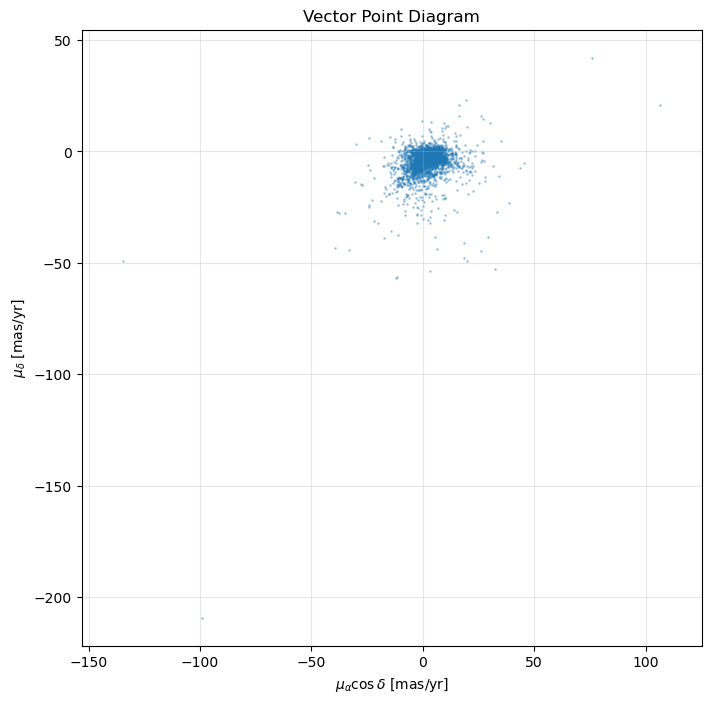

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(gaia_data['pmra'], gaia_data['pmdec'], s=1, alpha=0.3)
plt.xlabel(r'$\mu_\alpha \cos\delta$ [mas/yr]')
plt.ylabel(r'$\mu_\delta$ [mas/yr]')
plt.title('Vector Point Diagram')
plt.axis('equal')
plt.grid(True, alpha=0.3)

## Method 2: Peak Finding

In [8]:
from scipy.stats import gaussian_kde

# KDE in PM space
pm_data = np.vstack([gaia_data['pmra'], gaia_data['pmdec']])
kde = gaussian_kde(pm_data, bw_method=0.1)

# Evaluate on grid
pmra_grid = np.linspace(-20, 20, 200)
pmdec_grid = np.linspace(-20, 20, 200)
pmra_mesh, pmdec_mesh = np.meshgrid(pmra_grid, pmdec_grid)
positions = np.vstack([pmra_mesh.ravel(), pmdec_mesh.ravel()])
density = kde(positions).reshape(pmra_mesh.shape)

# Find peak
peak_idx = np.unravel_index(np.argmax(density), density.shape)
mu_alpha_cluster = pmra_grid[peak_idx[1]]
mu_delta_cluster = pmdec_grid[peak_idx[0]]

print(f"Cluster PM: ({mu_alpha_cluster:.2f}, {mu_delta_cluster:.2f}) mas/yr")

Cluster PM: (3.52, -2.11) mas/yr


## Method 3: Interative sigma clipping

In [12]:
import numpy as np

def find_cluster_pm_iterative(pmra, pmdec, n_iterations=5, sigma_clip=2.5):
    """
    Iteratively find cluster PM by sigma-clipping outliers.
    Robust to astropy MaskedColumn inputs and avoids operator-precedence
    broadcasting issues when computing Mahalanobis distances.
    """
    # Ensure plain numpy arrays (1D floats)
    pmra_arr = np.asarray(pmra).astype(float).ravel()
    pmdec_arr = np.asarray(pmdec).astype(float).ravel()
    
    pmra_work = pmra_arr.copy()
    pmdec_work = pmdec_arr.copy()
    
    mu_alpha = np.nan
    mu_delta = np.nan
    cov = np.eye(2)
    
    for iteration in range(n_iterations):
        if pmra_work.size < 3:
            print(f"Iteration {iteration}: too few stars ({pmra_work.size}), stopping.")
            break
        
        # Compute mean and covariance
        mu_alpha = np.mean(pmra_work)
        mu_delta = np.mean(pmdec_work)
        
        cov = np.cov(pmra_work, pmdec_work)
        cov = np.asarray(cov)
        # Ensure cov is 2x2
        if cov.ndim == 0:
            cov = np.array([[cov, 0.0], [0.0, cov]])
        elif cov.shape != (2, 2):
            cov = np.array([[np.var(pmra_work), 0.0],
                            [0.0, np.var(pmdec_work)]])
        
        # Mahalanobis distance (use einsum to avoid ambiguity)
        diff = np.column_stack([pmra_work - mu_alpha, pmdec_work - mu_delta])
        inv_cov = np.linalg.inv(cov)
        mahal_sq = np.einsum('ij,ij->i', diff @ inv_cov, diff)  # (N,)
        mahal_dist = np.sqrt(np.maximum(mahal_sq, 0.0))
        
        # Keep only stars within sigma_clip
        mask = mahal_dist < sigma_clip
        kept = np.sum(mask)
        total = len(pmra_work)
        pmra_work = pmra_work[mask]
        pmdec_work = pmdec_work[mask]
        
        print(f"Iteration {iteration}: kept {kept}/{total} stars")
    
    return mu_alpha, mu_delta, cov

mu_alpha_cl, mu_delta_cl, cov_cl = find_cluster_pm_iterative(
    gaia_data['pmra'], gaia_data['pmdec']
)

Iteration 0: kept 10900/11451 stars
Iteration 1: kept 9881/10900 stars
Iteration 2: kept 8893/9881 stars
Iteration 3: kept 8034/8893 stars
Iteration 4: kept 7339/8034 stars


(-146.50591190730728,
 118.44237979568632,
 -221.79937778292674,
 54.640684343680505)

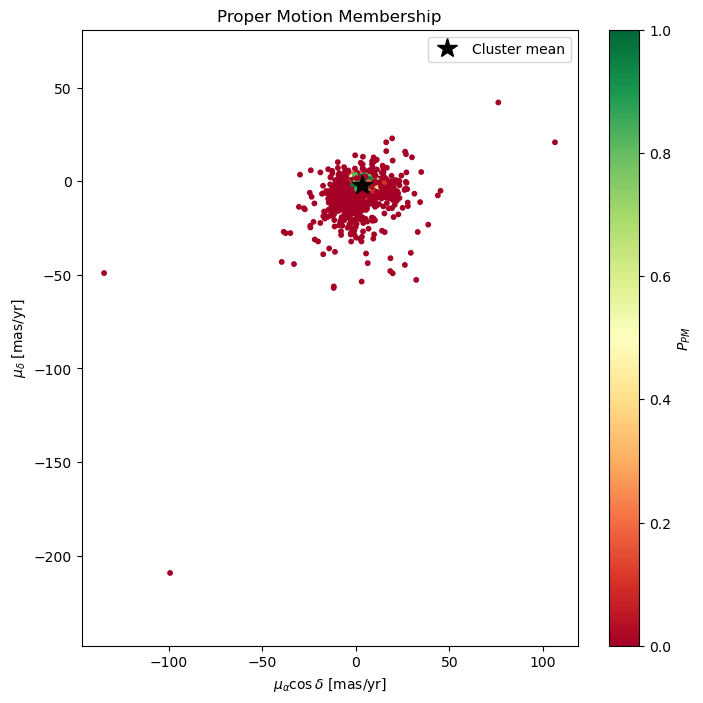

In [14]:
def proper_motion_membership(pmra, pmdec, pmra_err, pmdec_err,
                              mu_cluster, cov_cluster, cov_field=None):
    """
    Compute PM-based membership probability.
    
    Parameters:
    -----------
    pmra, pmdec : arrays
        Observed proper motions
    pmra_err, pmdec_err : arrays
        PM uncertainties
    mu_cluster : array [2]
        Cluster mean PM
    cov_cluster : array [2,2]
        Cluster PM covariance
    cov_field : array [2,2] or None
        Field PM covariance (if None, use broad uniform)
    
    Returns:
    --------
    prob : array
        Membership probabilities
    """
    N = len(pmra)
    prob = np.zeros(N)
    
    for i in range(N):
        # Observation
        mu_obs = np.array([pmra[i], pmdec[i]])
        
        # Total covariance (cluster + measurement)
        cov_obs = np.diag([pmra_err[i]**2, pmdec_err[i]**2])
        cov_total_cluster = cov_cluster + cov_obs
        
        # Likelihood for cluster
        diff_cluster = mu_obs - mu_cluster
        inv_cov_cluster = np.linalg.inv(cov_total_cluster)
        exponent_cluster = -0.5 * diff_cluster @ inv_cov_cluster @ diff_cluster
        norm_cluster = 1.0 / (2 * np.pi * np.sqrt(np.linalg.det(cov_total_cluster)))
        L_cluster = norm_cluster * np.exp(exponent_cluster)
        
        # Likelihood for field
        if cov_field is None:
            # Assume broad uniform: constant likelihood
            L_field = 1e-4  # Small constant
        else:
            cov_total_field = cov_field + cov_obs
            diff_field = mu_obs - np.mean([pmra, pmdec], axis=1)  # Field mean
            inv_cov_field = np.linalg.inv(cov_total_field)
            exponent_field = -0.5 * diff_field @ inv_cov_field @ diff_field
            norm_field = 1.0 / (2 * np.pi * np.sqrt(np.linalg.det(cov_total_field)))
            L_field = norm_field * np.exp(exponent_field)
        
        # Membership probability
        prob[i] = L_cluster / (L_cluster + L_field)
    
    return prob

# Example
mu_cluster = np.array([mu_alpha_cl, mu_delta_cl])
P_pm = proper_motion_membership(
    gaia_data['pmra'], gaia_data['pmdec'],
    gaia_data['pmra_error'], gaia_data['pmdec_error'],
    mu_cluster, cov_cl
)

# Visualize
plt.figure(figsize=(8, 8))
scatter = plt.scatter(gaia_data['pmra'], gaia_data['pmdec'], 
                      c=P_pm, s=10, cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(scatter, label='$P_{PM}$')
plt.xlabel(r'$\mu_\alpha \cos\delta$ [mas/yr]')
plt.ylabel(r'$\mu_\delta$ [mas/yr]')
plt.title('Proper Motion Membership')

# Add cluster center and covariance ellipse
from matplotlib.patches import Ellipse

eigenvalues, eigenvectors = np.linalg.eig(cov_cl)
angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
width, height = 2 * np.sqrt(eigenvalues) * 2.5  # 2.5-sigma ellipse

ellipse = Ellipse(mu_cluster, width, height, angle=angle, 
                  fill=False, edgecolor='black', lw=2, linestyle='--')
plt.gca().add_patch(ellipse)
plt.plot(*mu_cluster, 'k*', ms=15, label='Cluster mean')
plt.legend()
plt.axis('equal')

In [ ]:
def radial_membership(r, mag, r_cluster_center=0, 
                      density_profile_func=None, 
                      sigma_bg=None):
    """
    Compute radial/spatial membership probability.
    
    Parameters:
    -----------
    r : array
        Distance from cluster center
    mag : array
        Magnitude
    density_profile_func : callable
        Function rho_cluster(r) returning expected cluster density
    sigma_bg : float
        Background surface density
    """
    # Cluster density at each star's position
    if density_profile_func is None:
        # Default: Plummer profile
        a = 5.0  # arcmin, typical core radius
        def density_profile_func(r):
            return (1 + (r/a)**2)**(-2.5)
    
    rho_cluster = density_profile_func(r)
    
    # Normalize so total cluster stars = some fiducial number
    rho_cluster = rho_cluster / np.max(rho_cluster)  # Normalize to peak
    
    # Background density (constant)
    if sigma_bg is None:
        # Estimate from outer regions
        outer_mask = r > np.percentile(r, 90)
        sigma_bg = np.median(rho_cluster[outer_mask])  # Very rough
    
    rho_bg = sigma_bg * np.ones_like(r)
    
    # Membership probability
    prob = rho_cluster / (rho_cluster + rho_bg)
    
    return prob

# Example
r_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)  # in pixels or arcmin
P_spatial = radial_membership(r_from_center, stars_g)

## 4. Spatial Distribution Modeling

Cluster members follow a centrally concentrated density profile (e.g., Plummer, King), while field stars are uniformly distributed. We use radial position to compute a spatial membership probability.

---

In [ ]:
def combined_membership_probability(
    # CMD data
    color, mag, sigma_color, sigma_mag, iso_color, iso_mag,
    # PM data
    pmra, pmdec, pmra_err, pmdec_err, mu_cluster, cov_cluster,
    # Spatial data
    r, density_func,
    # Background properties
    sigma_bg_spatial, sigma_bg_pm,
    # Prior
    prior_member=0.5
):
    """
    Compute combined membership probability using Bayes' theorem.
    """
    N = len(color)
    P_member = np.zeros(N)
    
    for i in range(N):
        # === Likelihood for CLUSTER ===
        
        # 1. CMD likelihood
        d_cmd = isochrone_distance(
            np.array([color[i]]), np.array([mag[i]]),
            iso_color, iso_mag,
            np.array([sigma_color[i]]), np.array([sigma_mag[i]])
        )[0]
        L_cmd_cluster = np.exp(-0.5 * d_cmd**2)
        
        # 2. PM likelihood
        mu_obs = np.array([pmra[i], pmdec[i]])
        cov_obs = np.diag([pmra_err[i]**2, pmdec_err[i]**2])
        cov_total = cov_cluster + cov_obs
        diff = mu_obs - mu_cluster
        inv_cov = np.linalg.inv(cov_total)
        exponent = -0.5 * diff @ inv_cov @ diff
        norm = 1.0 / (2 * np.pi * np.sqrt(np.linalg.det(cov_total)))
        L_pm_cluster = norm * np.exp(exponent)
        
        # 3. Spatial likelihood
        L_spatial_cluster = density_func(r[i])
        
        # Combined cluster likelihood
        L_cluster = L_cmd_cluster * L_pm_cluster * L_spatial_cluster
        
        # === Likelihood for FIELD ===
        
        # 1. CMD: assume broad/uniform (field stars scattered)
        L_cmd_field = 0.01  # Constant (or could model field CMD)
        
        # 2. PM: broad Gaussian or uniform
        if sigma_bg_pm is not None:
            cov_field = sigma_bg_pm * np.eye(2)
            cov_total_field = cov_field + cov_obs
            # Assume field mean is Galactic at this location
            mu_field = np.array([0.0, 0.0])  # Placeholder
            diff_field = mu_obs - mu_field
            inv_cov_field = np.linalg.inv(cov_total_field)
            exponent_field = -0.5 * diff_field @ inv_cov_field @ diff_field
            norm_field = 1.0 / (2 * np.pi * np.sqrt(np.linalg.det(cov_total_field)))
            L_pm_field = norm_field * np.exp(exponent_field)
        else:
            L_pm_field = 0.001  # Constant
        
        # 3. Spatial: uniform
        L_spatial_field = sigma_bg_spatial
        
        # Combined field likelihood
        L_field = L_cmd_field * L_pm_field * L_spatial_field
        
        # === Posterior probability ===
        numerator = L_cluster * prior_member
        denominator = L_cluster * prior_member + L_field * (1 - prior_member)
        
        P_member[i] = numerator / denominator
    
    return P_member

# Full example
P_combined = combined_membership_probability(
    # CMD
    stars_color, stars_g, sigma_color, sigma_g, color_iso_M2, g_iso_M2,
    # PM
    gaia_data['pmra'], gaia_data['pmdec'], 
    gaia_data['pmra_error'], gaia_data['pmdec_error'],
    mu_cluster, cov_cl,
    # Spatial
    r_from_center, lambda r: (1 + (r/5.0)**2)**(-2.5),
    # Background
    0.1, 5.0,  # spatial and PM background levels
    # Prior
    0.3  # expect 30% members initially
)

## 5. Combined Bayesian Membership Probability

Now we combine all three criteria using Bayes' theorem. The key assumption is that CMD, PM, and spatial distributions are **statistically independent** for field stars (though correlated for cluster members).

---

## Visualization

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# CMD
ax = axes[0, 0]
sc = ax.scatter(stars_color, stars_g, c=P_combined, s=5, 
                cmap='RdYlGn', vmin=0, vmax=1, alpha=0.7)
ax.plot(color_iso_M2, g_iso_M2, 'k-', lw=2)
ax.set_xlabel('g - r')
ax.set_ylabel('g')
ax.invert_yaxis()
ax.set_title('CMD')

# PM diagram
ax = axes[0, 1]
ax.scatter(gaia_data['pmra'], gaia_data['pmdec'], 
           c=P_combined, s=10, cmap='RdYlGn', vmin=0, vmax=1)
ax.plot(*mu_cluster, 'k*', ms=15)
ax.set_xlabel(r'$\mu_\alpha \cos\delta$')
ax.set_ylabel(r'$\mu_\delta$')
ax.set_title('Proper Motion')
ax.axis('equal')

# Spatial distribution
ax = axes[0, 2]
ax.scatter(x, y, c=P_combined, s=5, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xlabel('X [arcmin]')
ax.set_ylabel('Y [arcmin]')
ax.set_title('Spatial')
ax.axis('equal')

# Probability histogram
ax = axes[1, 0]
ax.hist(P_combined, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0.5, color='red', linestyle='--', label='P=0.5 threshold')
ax.set_xlabel('$P_{member}$')
ax.set_ylabel('N stars')
ax.legend()
ax.set_title('Membership Probability Distribution')

# Radial profile (members vs all)
ax = axes[1, 1]
r_bins = np.logspace(-1, 1.5, 20)
r_centers = 0.5 * (r_bins[1:] + r_bins[:-1])

# All stars
N_all, _ = np.histogram(r_from_center, bins=r_bins)
# Weighted by membership
N_members, _ = np.histogram(r_from_center, bins=r_bins, weights=P_combined)

area = np.pi * (r_bins[1:]**2 - r_bins[:-1]**2)
sigma_all = N_all / area
sigma_members = N_members / area

ax.plot(r_centers, sigma_all, 'o-', label='All stars')
ax.plot(r_centers, sigma_members, 's-', label='Members (weighted)')
ax.set_xlabel('Radius [arcmin]')
ax.set_ylabel(r'Surface density [stars/arcmin$^2$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Radial Profile')
ax.grid(True, alpha=0.3)

# Cumulative distribution
ax = axes[1, 2]
sorted_P = np.sort(P_combined)[::-1]
cumsum = np.cumsum(sorted_P)
ax.plot(np.arange(len(sorted_P)), cumsum)
ax.axhline(np.sum(P_combined > 0.5), color='red', linestyle='--', 
           label=f'P>0.5: {np.sum(P_combined>0.5)} stars')
ax.set_xlabel('Star rank (sorted by P)')
ax.set_ylabel('Cumulative membership')
ax.legend()
ax.set_title('Cumulative Membership')
ax.grid(True, alpha=0.3)

plt.colorbar(sc, ax=axes[:, 2], label='$P_{member}$')
plt.tight_layout()

# Advanced Topics
## Iterative Refinement
- Initial cut (e.g., PM-based): flag likely members
- Compute background from likely non-members
- Recompute membership with better background model
- Iterate until convergence

## 6. Advanced Methods

The basic Bayesian framework can be enhanced with more sophisticated techniques:

1. **Iterative Refinement** - Use initial membership to re-estimate background, iterate to convergence
2. **Hierarchical Bayesian Models** - Jointly infer cluster parameters and membership (PyMC3/Stan)
3. **Machine Learning** - Random forests, neural networks trained on high-confidence members

---

In [ ]:
def iterative_membership_refinement(data, n_iterations=5):
    """
    Iteratively refine membership probabilities.
    """
    # Initialize with PM-only membership
    P_member = initial_pm_membership(data)
    
    for iteration in range(n_iterations):
        # Use current membership to estimate background
        is_member = P_member > 0.5
        is_field = ~is_member
        
        # Reestimate background properties
        mu_field = np.mean([data['pmra'][is_field], 
                           data['pmdec'][is_field]], axis=1)
        cov_field = np.cov(data['pmra'][is_field], 
                          data['pmdec'][is_field])
        
        # Reestimate cluster properties
        mu_cluster = np.mean([data['pmra'][is_member],
                             data['pmdec'][is_member]], axis=1)
        cov_cluster = np.cov(data['pmra'][is_member],
                            data['pmdec'][is_member])
        
        # Recompute membership
        P_member_new = combined_membership(data, mu_cluster, cov_cluster,
                                          mu_field, cov_field)
        
        # Check convergence
        delta = np.mean(np.abs(P_member_new - P_member))
        print(f"Iteration {iteration}: Δ = {delta:.4f}")
        
        P_member = P_member_new
        
        if delta < 1e-3:
            print("Converged!")
            break
    
    return P_member

## Hierarchical Bayesian Model

In [ ]:
import pymc3 as pm

with pm.Model() as model:
    # Cluster PM parameters
    mu_cluster = pm.Normal('mu_cluster', mu=0, sigma=10, shape=2)
    sigma_cluster = pm.HalfNormal('sigma_cluster', sigma=2, shape=2)
    
    # Field PM parameters
    mu_field = pm.Normal('mu_field', mu=0, sigma=20, shape=2)
    sigma_field = pm.HalfNormal('sigma_field', sigma=10, shape=2)
    
    # Membership fraction
    f_member = pm.Beta('f_member', alpha=2, beta=2)
    
    # Latent membership
    z = pm.Bernoulli('z', p=f_member, shape=N_stars)
    
    # Likelihood
    pm.Normal('obs_pmra',
              mu=pm.math.switch(z, mu_cluster[0], mu_field[0]),
              sigma=pm.math.switch(z, sigma_cluster[0], sigma_field[0]),
              observed=data['pmra'])
    
    pm.Normal('obs_pmdec',
              mu=pm.math.switch(z, mu_cluster[1], mu_field[1]),
              sigma=pm.math.switch(z, sigma_cluster[1], sigma_field[1]),
              observed=data['pmdec'])
    
    # Sample
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

# Extract membership probabilities
P_member = trace['z'].mean(axis=0)

## Machine Learning Approach

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Features
features = ['color', 'mag', 'pmra', 'pmdec', 'r_from_center']
X = data[features].values

# Labels (from strict cut)
strict_member = (P_cmd > 0.9) & (P_pm > 0.9)
strict_nonmember = (P_cmd < 0.1) | (P_pm < 0.1)

y = np.full(len(data), -1)
y[strict_member] = 1
y[strict_nonmember] = 0

# Train on labeled subset
labeled = y != -1
X_train = X[labeled]
y_train = y[labeled]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)

# Train
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict on all stars
P_member_rf = rf.predict_proba(X_scaled)[:, 1]

# Feature importance
importance = rf.feature_importances_
for feat, imp in zip(features, importance):
    print(f"{feat}: {imp:.3f}")